In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 98% 698M/714M [00:01<00:00, 271MB/s]
100% 714M/714M [00:02<00:00, 365MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip -d brain_mri_data

Archive:  lgg-mri-segmentation.zip
replace brain_mri_data/kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### This dataset was built from the LGG Brain MRI Segmentation set.
pairing each MRI image with its mask and assigning a binary label (1 -> tumor, 0 -> no tumor).

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

root = "brain_mri_data/lgg-mri-segmentation" #main path
data = [] #empty array
for folder_name in os.listdir(os.path.join(root, "kaggle_3m")):
    folder_path = os.path.join(root, "kaggle_3m", folder_name)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.endswith(".tif") and not fname.endswith("_mask.tif"):
                img_path = os.path.join(folder_path, fname)
                mask_path = os.path.join(folder_path, fname.replace(".tif", "_mask.tif"))
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    label = 1 if np.max(mask) > 0 else 0 # Convert label to string
                    data.append({"image_path": img_path, "mask_path": mask_path, "label": label})

df = pd.DataFrame(data)
display(df.head())

,image_path,mask_path,label
0,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,0
1,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,1
2,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,0
3,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,0
4,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,brain_mri_data/lgg-mri-segmentation/kaggle_3m/...,1


preparing MRI images and their segmentation masks.
- Both the input image and its mask are resized to 224×224 pixels.
- The MRI image is normalized to values between 0 and 1, and reshaped to have a single channel.
-  The function returns the preprocessed image and mask in a format suitable for training segmentation models.

In [ ]:
IMG_SIZE = 224

def load_image_mask(img_path, mask_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return img, mask


In [ ]:
def create_dataset(df):
    images, masks = [], []
    for _, row in df.iterrows():
        img, mask = load_image_mask(row["image_path"], row["mask_path"])
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

Splitting data to test and train

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_df["label"] = train_df["label"].astype(str) # Convert label to string
val_df["label"] = val_df["label"].astype(str) # Convert label to string
test_df["label"] = test_df["label"].astype(str) # Convert label to string

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 2357 Val: 786 Test: 786


In [ ]:
X_train, y_train = create_dataset(train_df)
X_val, y_val     = create_dataset(val_df)
X_test, y_test   = create_dataset(test_df)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (2357, 224, 224, 3) (2357, 224, 224, 1)
Val: (786, 224, 224, 3) (786, 224, 224, 1)
Test: (786, 224, 224, 3) (786, 224, 224, 1)


### U-Net Model for Brain Tumor Segmentation

This section defines a **U-Net** architecture for MRI tumor segmentation.  
- **Encoder:** extracts features and downsamples the image.  
- **Bottleneck:** captures deep features.  
- **Decoder:** upsamples and combines features with skip connections.  
- **Output:** binary mask (tumor vs. background) using sigmoid activation.  


In [ ]:
# -----------------------------
# U-Net model
# -----------------------------
from tensorflow.keras import layers, models

# Basic feature extraction
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x) #filter 3x3, relu is an activation function
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

##picture encoder (downsampling) -> Feature extraction "this is a tumor"
def encoder_block(x, filters):
    c = conv_block(x, filters)      #extract the picture features
    p = layers.MaxPool2D((2,2))(c)  #downsampling picture to half 224x224 -> 112x112
    return c, p   #returns the features and the downsampled picture

#picture decoder (upsampling) -> "the tumor exact location"
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x) #
    x = layers.Concatenate()([x, skip]) #connect the decoded and encoded image
    x = conv_block(x, filters)
    return x

#Building the model
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    b = conv_block(p4, 512)

    d1 = decoder_block(b, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4) #sigmoid = binary output

    model = models.Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet()
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

### Loss Function & Metrics

This section defines the evaluation metric and loss function for segmentation:  
- **Dice Coefficient (`dice_coef`)**: measures overlap between the predicted mask and the ground truth (higher is better).  
- **Dice Loss (`dice_loss`)**: derived from the Dice coefficient, used to optimize the model (lower is better).  


In [ ]:
# -----------------------------
# Loss Function & Metrics
# -----------------------------

# measure predicted mask with the real mask
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1]) #transform images to 1D
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f) #compare pixels of the pred and real
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=dice_loss,
              metrics=[dice_coef, "accuracy"])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_unet.h5", save_best_only=True, monitor="val_dice_coef", mode="max"),
    tf.keras.callbacks.EarlyStopping(monitor="val_dice_coef", patience=8, mode="max", restore_best_weights=True)
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7545 - dice_coef: 0.0609 - loss: 0.9391

295/295 ━━━━━━━━━━━━━━━━━━━━ 126s 281ms/step - accuracy: 0.7548 - dice_coef: 0.0609 - loss: 0.9391 - val_accuracy: 0.0615 - val_dice_coef: 0.0218 - val_loss: 0.9781
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9019 - dice_coef: 0.1039 - loss: 0.8961

295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9019 - dice_coef: 0.1040 - loss: 0.8960 - val_accuracy: 0.9367 - val_dice_coef: 0.1717 - val_loss: 0.8270
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9313 - dice_coef: 0.1424 - loss: 0.8576

295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.9314 - dice_coef: 0.1425 - loss: 0.8575 - val_accuracy: 0.9616 - val_dice_coef: 0.2728 - val_loss: 0.7251
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9604 - dice_coef: 0.2090 - loss: 0.7910

295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.9604 - dice_coef: 0.2090 - loss: 0.7910 - val_accuracy: 0.9742 - val_dice_coef: 0.3302 - val_loss: 0.6672
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9711 - dice_coef: 0.2793 - loss: 0.7207

295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.9711 - dice_coef: 0.2794 - loss: 0.7206 - val_accuracy: 0.9920 - val_dice_coef: 0.5346 - val_loss: 0.4613
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9841 - dice_coef: 0.3696 - loss: 0.6304

295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.9841 - dice_coef: 0.3697 - loss: 0.6303 - val_accuracy: 0.9938 - val_dice_coef: 0.5610 - val_loss: 0.4347
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9899 - dice_coef: 0.4897 - loss: 0.5103

295/295 ━━━━━━━━━━━━━━━━━━━━ 45s 153ms/step - accuracy: 0.9899 - dice_coef: 0.4898 - loss: 0.5102 - val_accuracy: 0.9947 - val_dice_coef: 0.6213 - val_loss: 0.3740
Epoch 8/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9918 - dice_coef: 0.5656 - loss: 0.4344

295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.9918 - dice_coef: 0.5656 - loss: 0.4344 - val_accuracy: 0.9929 - val_dice_coef: 0.6358 - val_loss: 0.3594
Epoch 9/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.9934 - dice_coef: 0.6225 - loss: 0.3775 - val_accuracy: 0.9951 - val_dice_coef: 0.5878 - val_loss: 0.4077
Epoch 10/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9940 - dice_coef: 0.6451 - loss: 0.3549

295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.9940 - dice_coef: 0.6451 - loss: 0.3549 - val_accuracy: 0.9957 - val_dice_coef: 0.6633 - val_loss: 0.3316
Epoch 11/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.9943 - dice_coef: 0.6902 - loss: 0.3098 - val_accuracy: 0.9794 - val_dice_coef: 0.4360 - val_loss: 0.5606
Epoch 12/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9940 - dice_coef: 0.6906 - loss: 0.3094

295/295 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.9940 - dice_coef: 0.6906 - loss: 0.3094 - val_accuracy: 0.9962 - val_dice_coef: 0.7170 - val_loss: 0.2775
Epoch 13/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.9958 - dice_coef: 0.7429 - loss: 0.2571 - val_accuracy: 0.9958 - val_dice_coef: 0.6919 - val_loss: 0.3028
Epoch 14/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9956 - dice_coef: 0.7421 - loss: 0.2579 - val_accuracy: 0.9951 - val_dice_coef: 0.6984 - val_loss: 0.2963
Epoch 15/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9960 - dice_coef: 0.7336 - loss: 0.2664

295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.9960 - dice_coef: 0.7337 - loss: 0.2663 - val_accuracy: 0.9966 - val_dice_coef: 0.7326 - val_loss: 0.2618
Epoch 16/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9961 - dice_coef: 0.7427 - loss: 0.2573

295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.9961 - dice_coef: 0.7427 - loss: 0.2573 - val_accuracy: 0.9966 - val_dice_coef: 0.7331 - val_loss: 0.2613
Epoch 17/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9961 - dice_coef: 0.7696 - loss: 0.2304

295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.9961 - dice_coef: 0.7696 - loss: 0.2304 - val_accuracy: 0.9965 - val_dice_coef: 0.7342 - val_loss: 0.2602
Epoch 18/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9959 - dice_coef: 0.7675 - loss: 0.2325

295/295 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.9959 - dice_coef: 0.7675 - loss: 0.2325 - val_accuracy: 0.9970 - val_dice_coef: 0.7668 - val_loss: 0.2274
Epoch 19/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.9964 - dice_coef: 0.7961 - loss: 0.2039 - val_accuracy: 0.9971 - val_dice_coef: 0.7611 - val_loss: 0.2331
Epoch 20/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.9948 - dice_coef: 0.7719 - loss: 0.2281 - val_accuracy: 0.9969 - val_dice_coef: 0.7381 - val_loss: 0.2563
Epoch 21/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.9944 - dice_coef: 0.7673 - loss: 0.2327 - val_accuracy: 0.9942 - val_dice_coef: 0.5322 - val_loss: 0.4637
Epoch 22/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 159ms/step - accuracy: 0.9955 - dice_coef: 0.7464 - loss: 0.2536 - val_accuracy: 0.9969 - val_dice_coef: 0.7543 - val_loss: 0.2399
Epoch 23/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.9962 - dice_coef: 0.7908 - loss: 0.2092 - val_accuracy: 0.9971

295/295 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.9965 - dice_coef: 0.7983 - loss: 0.2017 - val_accuracy: 0.9972 - val_dice_coef: 0.7771 - val_loss: 0.2170
Epoch 26/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 83s 159ms/step - accuracy: 0.9954 - dice_coef: 0.8016 - loss: 0.1984 - val_accuracy: 0.9970 - val_dice_coef: 0.7677 - val_loss: 0.2265
Epoch 27/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9958 - dice_coef: 0.7843 - loss: 0.2157

295/295 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.9958 - dice_coef: 0.7843 - loss: 0.2157 - val_accuracy: 0.9972 - val_dice_coef: 0.7808 - val_loss: 0.2133
Epoch 28/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.9950 - dice_coef: 0.7691 - loss: 0.2309 - val_accuracy: 0.9970 - val_dice_coef: 0.7637 - val_loss: 0.2305
Epoch 29/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step - accuracy: 0.9967 - dice_coef: 0.7857 - loss: 0.2143 - val_accuracy: 0.9973 - val_dice_coef: 0.7761 - val_loss: 0.2180
Epoch 30/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9957 - dice_coef: 0.7974 - loss: 0.2026

295/295 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.9957 - dice_coef: 0.7975 - loss: 0.2025 - val_accuracy: 0.9975 - val_dice_coef: 0.7856 - val_loss: 0.2084


In [ ]:
loss, dice, acc = model.evaluate(X_test, y_test)
print(f"Test Dice: {dice:.4f}, Accuracy: {acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - accuracy: 0.9979 - dice_coef: 0.8712 - loss: 0.1289
Test Dice: 0.8759, Accuracy: 0.9976


### Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


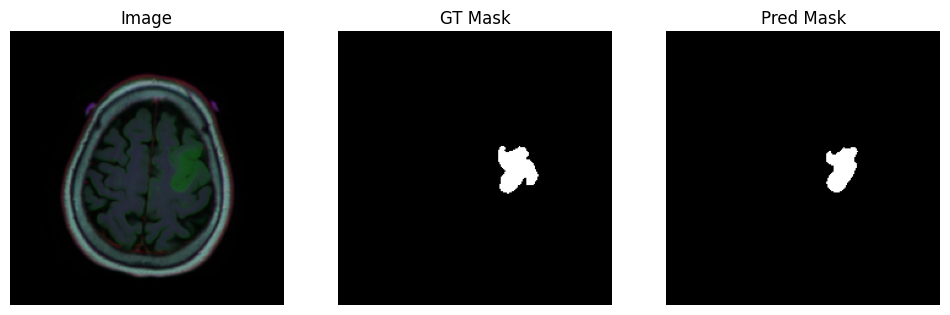

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


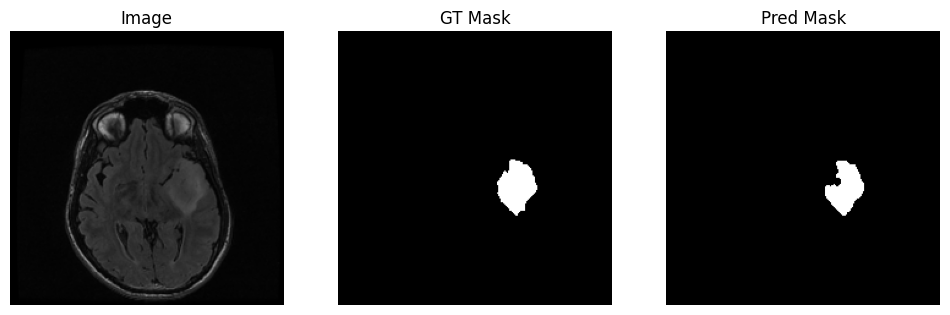

In [ ]:
import matplotlib.pyplot as plt
def show_sample(i):
    img = X_test[i]
    mask = y_test[i]
    pred = model.predict(img[np.newaxis,...])[0,...,0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask[:,:,0], cmap="gray"); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap="gray"); plt.title("Pred Mask"); plt.axis("off")
    plt.show()

show_sample(0)
show_sample(1)

#### Data Loading & Preprocessing

This function loads and preprocesses MRI images (and masks if needed).  
- **Resizes** images/masks to 224×224.  
- **Normalizes** images to [0,1].  
- For **classification**: ensures 3 channels.  
- For **segmentation**: loads the mask, binarizes it, and adds a channel dimension.  


In [ ]:
IMG_SIZE = 224

def load_and_preprocess(img_path, mask_path, for_classification=True):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    if for_classification:
        img = np.repeat(img[..., :1], 3, axis=-1)  # 3 channels
    mask = None
    if not for_classification:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = (mask > 0).astype(np.float32)
        mask = mask[..., np.newaxis]
    return img, mask

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

####  Data Augmentation for Training


In [ ]:
IMG_SIZE = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

Found 2357 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 786 validated image filenames belonging to 2 classes.


In [ ]:
#Handles imbalance in the dataset, the rare classes get higher weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights = dict(zip(np.unique(train_df["label"]), class_weights))
print("Class Weights:", class_weights)


Class Weights: {'0': np.float64(0.768754076973255), '1': np.float64(1.4302184466019416)}


In [ ]:
# 1.loads pretrained weights from ImageNet
# 2. removes that classification head
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze first

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

#### ResNet50 for Tumor Classification

 **Base model:** ResNet50 pre-trained on ImageNet (top layers removed).  


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7148 - loss: 0.6846 - val_accuracy: 0.3499 - val_loss: 20.6565 - learning_rate: 0.0010
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.8543 - loss: 0.3791 - val_accuracy: 0.6501 - val_loss: 47.1828 - learning_rate: 0.0010
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.8656 - loss: 0.3066 - val_accuracy: 0.6501 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 573ms/step - accuracy: 0.8883 - loss: 0.2752 - val_accuracy: 0.6501 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 37s 493ms/step - accuracy: 0.9039 - loss: 0.2528 - val_accuracy: 0.3499 - val_loss: 18.1230 - learning_rate: 0.0010
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 37s 495ms/step - accuracy: 0.9230 - loss: 0.2078 - val_accuracy: 0.6501 - val_loss: 2.5333 - learning_rate: 0.0010
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 615ms/step - accuracy: 0.9216 - loss: 0

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9636 - loss: 0.1736
Test Accuracy: 95.93%


#### Classification Model Evaluation

This section evaluates the trained ResNet50 model on the test set:  
- **Predictions:** generate class probabilities and convert to binary labels.  
- **Confusion Matrix:** shows counts of true positives, true negatives, false positives, and false negatives.  
- **Classification Report:** provides precision, recall, F1-score, and accuracy.  

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
test_labels = test_generator.classes
test_pred_probs = model.predict(test_generator)
test_preds = (test_pred_probs > 0.5).astype(int).flatten()


# Calculate and display confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

# Calculate and display classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step
Confusion Matrix:
[[503   9]
 [ 23 251]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       512
           1       0.97      0.92      0.94       274

    accuracy                           0.96       786
   macro avg       0.96      0.95      0.95       786
weighted avg       0.96      0.96      0.96       786



#### Saving and downloading the **Segmentation** and **Classification** models

In [ ]:
ModelCheckpoint("best_unet.keras", monitor="val_dice_coef", mode="max", save_best_only=True)
model.save("unet_model.keras")


In [ ]:
ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
model.save("classifier_model.keras")


In [ ]:
from google.colab import files
files.download("best_unet.h5")        # segmentation model
files.download("best_model.keras")    # classification model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow import keras

# Load models (use .keras if you saved them in the new format)
unet = keras.models.load_model("unet_model.keras", compile=True)
unet.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=dice_loss,
              metrics=[dice_coef, "accuracy"])
classifier = keras.models.load_model("classifier_model.keras", compile=False)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 218 variables whereas the saved optimizer has 434 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
